<a href="https://colab.research.google.com/github/AyozeGS/IABD/blob/main/7RO/T6/7RO_Chessman_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ayoze Gil Sosa




# Chessman image dataset

Este cuaderno consiste en la clasificación de imágenes de las piezas del ajedrez usando redes neuronales convolucionales (CNN).

Las imágenes a usar para el entrenamiento y testeo de la mismas se han descargado originalmente de la paltaforma Kaggle.

Dataset Kaggle: https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset

Sin embargo, para realizar esta actividad se cargan directamente desde un repositorio de Github

Dataset Github: https://github.com/AyozeGS/IABD/raw/main/7RO/T6/data.zip

In [3]:
!pip install scikeras

## Importanción de librerías

In [318]:
import zipfile
import os
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from keras import regularizers
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

## Carga de los datos

En primer lugar se descarga el fichero zip y se extrae en la ruta indicada.

In [8]:
# Rutas
zip_path = '/content/chess.zip'
extraction_path = '/content/'

# Bajamos los datos del Github
keras.utils.get_file(fname=zip_path,
                     origin="https://github.com/AyozeGS/IABD/raw/main/7RO/T6/data.zip")

# Descomprimir el archivo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f'Archivos extraídos en {extraction_path}')

Archivos extraídos en /content/


Se comprueban la cantidad de imágenes que tenemos de cada pieza y se realiza un mapeo de las categorías.

In [9]:
data_path = '/content/Chessman-image-dataset/Chess/'

# Carga todos los CSV en la carpeta en un diccionario de listas de DataFrames
for root, dirs, files in os.walk(data_path):
  if len(files):
        dir = root.split('/')[-1]
        count = 0
        for file in files:
          if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            count += 1
        print(dir, '->', count, 'imágenes')

Queen -> 77 imágenes
King -> 75 imágenes
Pawn -> 106 imágenes
Knight -> 105 imágenes
Bishop -> 86 imágenes
Rook -> 102 imágenes


## Creación del dataset

Funciones que cargan las imágenes del directorio y utilizan la librería PIL para hacer un reescalado y adaptarlas todas al mismo tamaño.

In [10]:
# Función que carga una imagen RGB utilizando la librería PIL permitiendo pasa
"""
  Args:
      filename: ruta completa del fichero a leer
      width: anchura de las imágenes creadas. 64 píxeles por defecto
      height: altura de la imágenes creadas. 64 píxeles por defecto
      on_gray_scale: Indica si las imágenes cargadas serán en escala de grises (1 capa). False por defecto
  Returns:
      image, imagen cargadas con tamaño width x height
  """
def get_image(filename, height=None, width=None, on_gray_scale=False, transform_tech=None):

  image = Image.open(filename)

  image = image.convert('RGB')
  if on_gray_scale:
    image = ImageOps.grayscale(image)

  if height and width:
    image = image.resize((width, height))

  match transform_tech:
    case 'flip':
      image = ImageOps.flip(image)
    case 'invert':
      image = ImageOps.invert(image)
    case 'mirror':
      image = ImageOps.mirror(image)
    case _:
      pass

  return image

# Función que crea un set de imágenes y sus etiquetas a partir de los ficheros de un directorio.
"""
  Args:
      dirname: directorio completo del que leer los datos
      map_characters: variable de mapeo entre labels y personajes
      width: anchura de las imágenes creadas. 64 píxeles por defecto
      height: altura de la imágenes creadas. 64 píxeles por defecto
      verbose: si es True, muestra información de las imágenes cargadas
      on_gray_scale: Cargadas la imagen en escala de grises (1 capa). False por defecto
  Returns:
      X, array con todas las imágenes cargadas con tamaño width x height
      y: array con las labels de correspondientes a cada imagen
  """
def load_set(dirname, map_characters, height=None, width=None, verbose=True, on_gray_scale=False, transform_techs=[]):

  X = []
  y = []

  for label, category in map_characters.items():

    files = os.listdir(os.path.join(dirname, category))
    images = [file for file in files if file.lower().endswith(("jpg", 'png', 'jpeg', 'gif'))]
    transform_techs_list = ['flip', 'invert', 'mirror']
    valid_transform_techs = np.intersect1d(transform_techs, transform_techs_list)
    invalid_transform_techs = np.setdiff1d(transform_techs, transform_techs_list)

    if verbose:
      print("Halladas {} imágenes de {}".format(len(images), category))

    for image_name in images:

      filename = os.path.join(dirname, category, image_name)

      image = get_image(filename, height=height, width=width, on_gray_scale=on_gray_scale)
      X.append(np.array(image))
      y.append(label)

      for transform_tech in valid_transform_techs:
            image = get_image(filename, height=height, width=width, on_gray_scale=on_gray_scale, transform_tech=transform_tech)
            X.append(np.array(image))
            y.append(label)

    if verbose:
      loaded_images = images *  (len(valid_transform_techs) +1)
      print("Cargadas {} imágenes de {}".format(len(loaded_images), category))

  return np.array(X), np.array(y)

Se cargan las imágenes y se crea el dataset llamando a las funciones anteriores

In [172]:
# Parámetros para cargar las imágenes
IMG_SIZE = 64
transform_techs=['flip', 'invert', 'mirror']
on_gray_scale=False

# Indicamos el directorio donde están las imágenes a cargar
data_path = '/content/Chessman-image-dataset/Chess/'

# Esta variable contiene un mapeo de número de clase a la pieza que corresponde.
MAP_CHARACTERS = {indice: piece for indice, piece in enumerate(os.listdir(data_path))}
print("Clases:", MAP_CHARACTERS, "\n")

# Cargamos los datos. Decidimos si queremos cargar las imágenes en el formato RGB, en escala de grises o en ambos.
X_rgb, y = load_set(data_path, MAP_CHARACTERS, height=IMG_SIZE, width=IMG_SIZE, verbose=True,
                on_gray_scale=on_gray_scale, transform_techs=transform_techs)

print(f"\nCargadas {X.shape[0]} imágenes de dimensiones {X.shape[1:]}")

Clases: {0: 'Queen', 1: 'King', 2: 'Pawn', 3: 'Knight', 4: 'Bishop', 5: 'Rook'} 

Halladas 77 imágenes de Queen
Cargadas 308 imágenes de Queen
Halladas 75 imágenes de King
Cargadas 300 imágenes de King
Halladas 106 imágenes de Pawn
Cargadas 424 imágenes de Pawn
Halladas 105 imágenes de Knight
Cargadas 420 imágenes de Knight
Halladas 87 imágenes de Bishop
Cargadas 348 imágenes de Bishop
Halladas 102 imágenes de Rook
Cargadas 408 imágenes de Rook

Cargadas 2208 imágenes de dimensiones (64, 64, 3)


Vamos a hacer lo mismo con las imágenes en escala de grises

In [110]:
X_gray, y = load_set(data_path, MAP_CHARACTERS, height=IMG_SIZE, width=IMG_SIZE, verbose=True,
                on_gray_scale=True, transform_techs=transform_techs)

print(f"\nCargadas {X_gray.shape[0]} imágenes de dimensiones {X_gray.shape[1:]}")

Halladas 77 imágenes de Queen
Cargadas 308 imágenes de Queen
Halladas 75 imágenes de King
Cargadas 300 imágenes de King
Halladas 106 imágenes de Pawn
Cargadas 424 imágenes de Pawn
Halladas 105 imágenes de Knight
Cargadas 420 imágenes de Knight
Halladas 87 imágenes de Bishop
Cargadas 348 imágenes de Bishop
Halladas 102 imágenes de Rook
Cargadas 408 imágenes de Rook

Cargadas 2208 imágenes de dimensiones (64, 64)


Función para visualizar las imágenes generadas

In [112]:
def visualize_image_layers(image, show_layers=False, layers_title=['Color', 'R', 'G', 'B'], cmap="Greys_r"):

  # Comprueba que haya varias capas en la imagen
  if len(image.shape) == 3 and show_layers:
    num_subplots = image.shape[2] + 1
  else:
    num_subplots = 1

  # Define los subplots
  fig, ax = plt.subplots(nrows=1, ncols=num_subplots, figsize=(3*num_subplots,3))

  # Muetsro una capa

  if num_subplots == 1:
    im = ax.imshow(image, cmap=cmap)
    ax.set_title(layers_title[0])

  # Muestro varias capas
  else:
    for i in range(num_subplots):
      if i == 0:
        im = ax[i].imshow(image)
      else:
        im = ax[i].imshow(image[:,:,i-1], cmap=cmap)
      ax[i].set_title(layers_title[i])

  fig.subplots_adjust(right=0.85)
  cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
  fig.colorbar(im, cax=cbar_ax)

Se muestra una imagen con todas sus capas y sus transformaciones

Queen


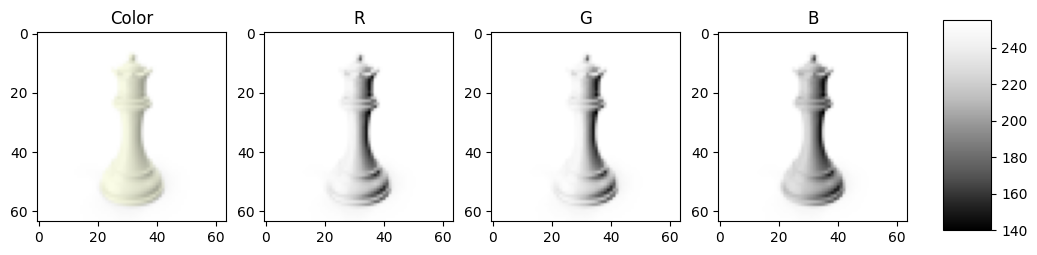

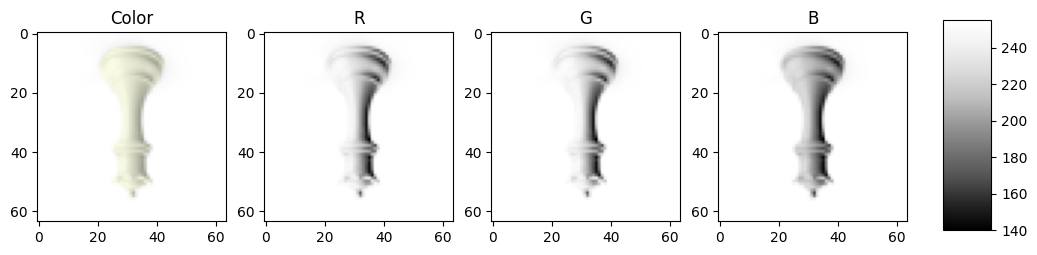

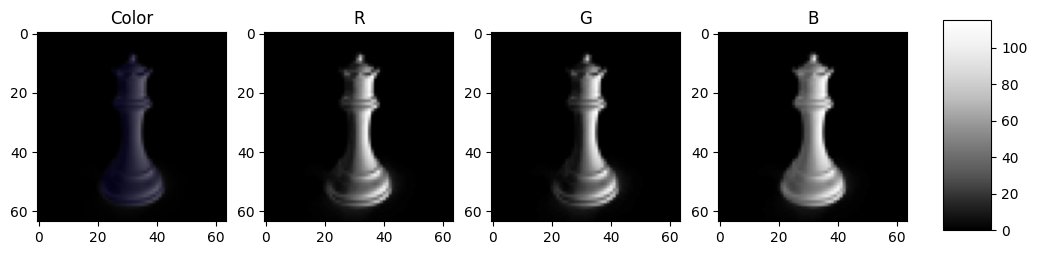

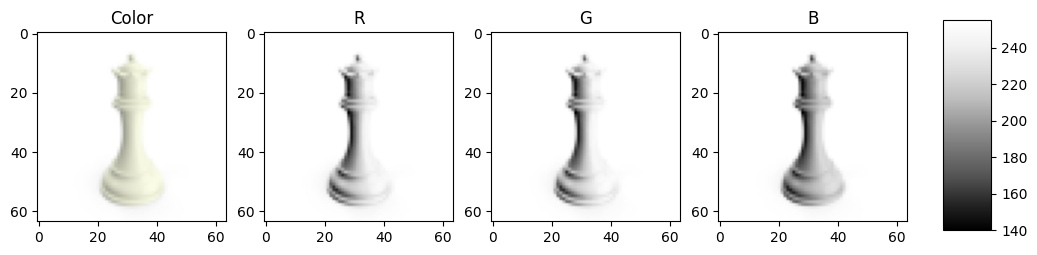

In [173]:
number = 42
image_variants = (len(transform_techs) + 1)
mapped_number = number * image_variants
print(MAP_CHARACTERS[y[mapped_number]]) # Acceso al diccionario
layers_title = ["Gray"] if on_gray_scale else ['Color', 'R', 'G', 'B']

for i in range(image_variants):
  visualize_image_layers(X_rgb[mapped_number+i], show_layers=True, layers_title=layers_title)

La misma imagen en escala de grises

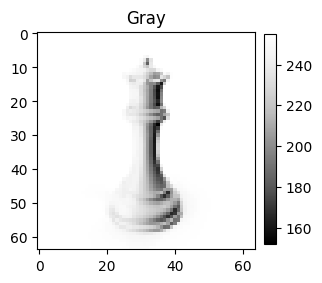

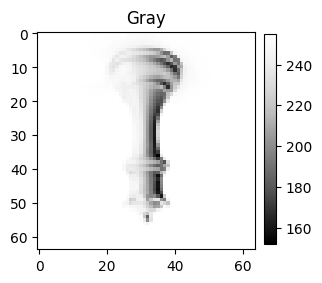

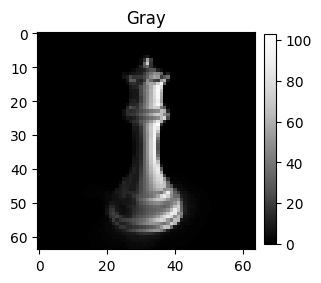

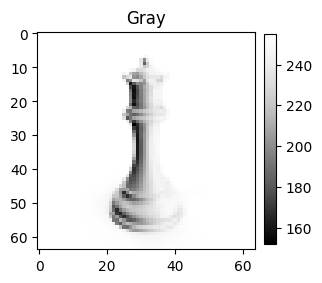

In [111]:
for i in range(image_variants):
  visualize_image_layers(X_gray[mapped_number+i], show_layers=True, layers_title=["Gray"])

# Separación en muestras de entrenamiento y test

Se normalizan todas las valores de las imágenes entre 0 y 1

In [174]:
# Preprocessing normalización de las imágenes
X_rgb = X_rgb / 255.0

Hacemos lo mismo con las imágenes en escala de grises

In [113]:
X_gray = X_gray / 255.0

División de grupos de imágenes en test y train

Vamos a barajar aleatoriamente los datos manteniendo un balance entre las diferentes piezas y sin separar las del mismo grupo.

In [175]:
# Etiqueta de cada grupo de imágenes (original y transformaciones)
y_groups = y[::len(transform_techs) + 1]
# Índices de cada grupo (múltiples de 4)
group_indexes = np.array([i*4 for i in range(int(len(y)/(len(transform_techs) + 1)))])

# Usaremos la serie completa de 'y' para hacer el split, manteniendo las proporciones de cada clase
group_indexes_train, group_indexes_test, y_groups_train, y_groups_test = train_test_split(group_indexes, y_groups, test_size=0.3, stratify=y_groups, random_state=42)

# Visualización de registros de cada categoría
train_samples = pd.Series(y_groups_train).value_counts()
test_samples = pd.Series(y_groups_test).value_counts()
samples = pd.concat([train_samples, train_samples/len(y_groups_train), test_samples, test_samples/len(y_groups_test)],
                    axis=1,
                    keys=["train", "train(%)", "test", "test(%)"])
samples.index = [MAP_CHARACTERS[i] for i in samples.index]
samples

,train,train(%),test,test(%)
Pawn,74,0.191710,32,0.192771
Knight,73,0.189119,32,0.192771
Rook,71,0.183938,31,0.186747
Bishop,61,0.158031,26,0.156627
Queen,54,0.139896,23,0.138554
King,53,0.137306,22,0.132530


Convertimos la clase y a valores categóricos

In [177]:
# convert class vectors to binary class matrices
y=keras.utils.to_categorical(y,len(MAP_CHARACTERS))

Reordenamos las muestras X e y en función de los índices de los grupos extendidos de los aleatorizados anteriormente.

In [183]:
# Extendemos los índices añadiendo los índices de las variables de cada imagen
train_indexes = np.concatenate([np.arange(start, start+(len(transform_techs) + 1)) for start in group_indexes_train])
test_indexes = np.concatenate([np.arange(start, start+(len(transform_techs) + 1)) for start in group_indexes_test])
# Reordenamos X e y con los índices calculados
X_rgb_train, X_rgb_test = X_rgb[train_indexes], X_rgb[test_indexes]
y_train, y_test = y[train_indexes], y[test_indexes]
print("X_train:", X_rgb_train.shape)
print("X_test:", X_rgb_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (1544, 64, 64, 3)
X_test: (664, 64, 64, 3)
y_train: (1544, 6)
y_test: (664, 6)


Comprobamos que los grupos de imágenes no se han separado accediendo a 4 muestras consecutivas

Pawn


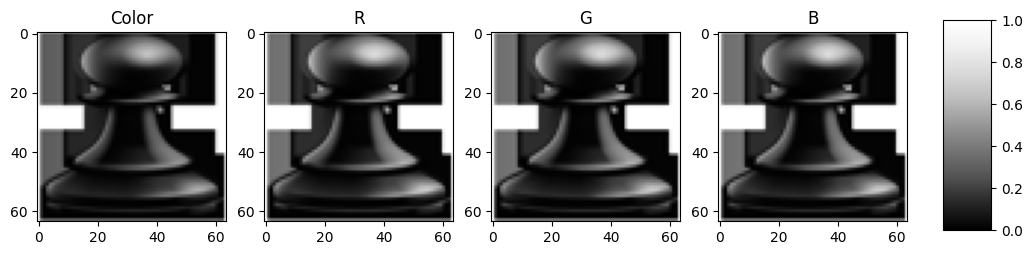

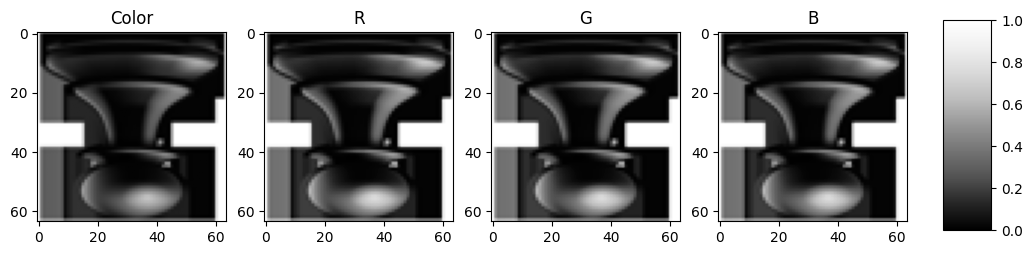

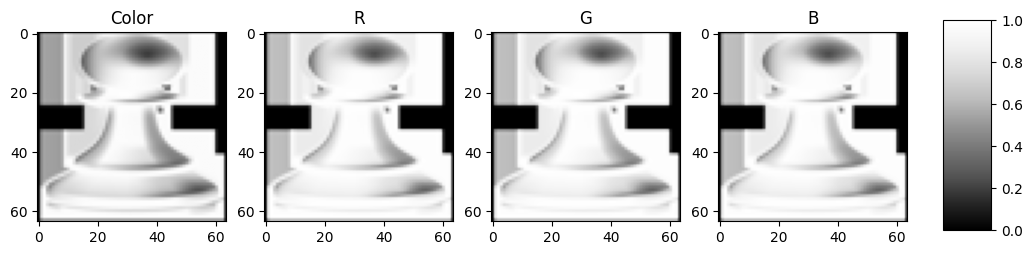

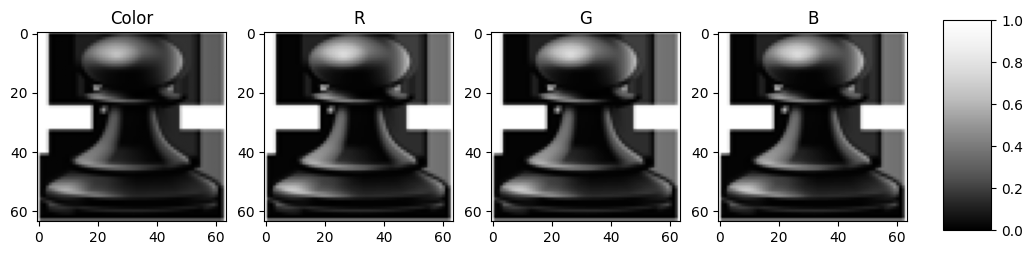

In [179]:
#Comprobamos las imágenes normalizadas y manteniendo el grupo
number = 42
image_variants = (len(transform_techs) + 1)
mapped_number = number * image_variants
print(MAP_CHARACTERS[np.argmax(y_train[mapped_number])]) # Acceso al diccionario
layers_title = ["Gray"] if on_gray_scale else ['Color', 'R', 'G', 'B']

for i in range(image_variants):
  visualize_image_layers(X_rgb_train[mapped_number+i], show_layers=True, layers_title=layers_title)

Repetimos la operación con las imágenes en escala de grises

In [180]:
X_gray_train, X_gray_test = X_gray[train_indexes], X_gray[test_indexes]
print("X_train:", X_gray_train.shape)
print("X_test:", X_gray_test.shape)

X_train: (1544, 64, 64)
X_test: (664, 64, 64)


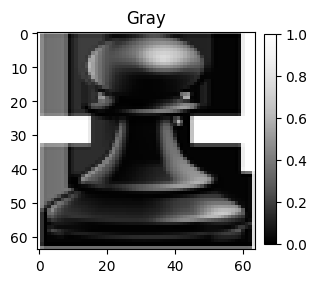

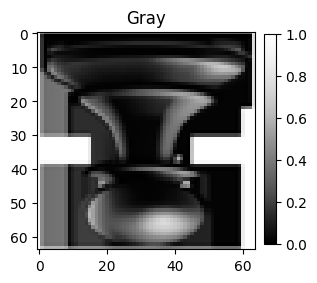

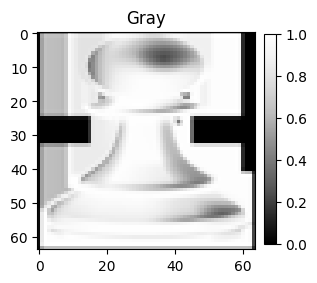

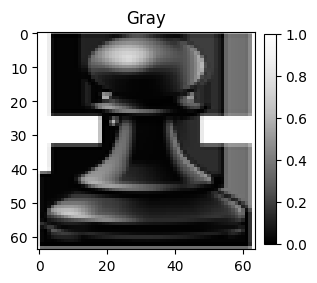

In [181]:
for i in range(image_variants):
  visualize_image_layers(X_gray_train[mapped_number+i], show_layers=True, layers_title=['Gray'])

# Entrenamiento

## Funciones de gráficas de resultados

Funciones con las gráficas de resultados de varios modelos

In [198]:
# Compara accuracys de varios entrenamientos o modelos
def plot_compare_accs(histories, ax, names, title, color=["blue", "orange", "green", "red", "black"]):
  for idx, history in enumerate(histories):
    ax.plot(histories[idx].history['accuracy'], color=color[idx])
    ax.plot(histories[idx].history['val_accuracy'], '--', color=color[idx])
  ax.set_title(title)
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epoch')
  ax.legend(np.concatenate([('Train ' + names[idx], 'Val ' + names[idx]) for idx, history in enumerate(histories)]), loc='upper left')

# Compara losses de varios entrenamientos o modelos
def plot_compare_losses(histories, ax, names, title, color=["blue", "orange", "green", "red", "black"]):
  for idx, history in enumerate(histories):
    ax.plot(histories[idx].history['loss'], color=color[idx])
    ax.plot(histories[idx].history['val_loss'], '--', color=color[idx])
  ax.set_title(title)
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epoch')
  ax.legend(np.concatenate([('Train ' + names[idx], 'Val ' + names[idx]) for idx, history in enumerate(histories)]), loc='lower left')

# Imprime gráficas con el accuracy y el loss
def plot_compare_scores(histories, names):
  fig,ax = plt.subplots(ncols=2, figsize=(10,5))
  plot_compare_accs(histories, ax[0], names, title="Model Accuracy")
  plot_compare_losses(histories, ax[1], names, title="Model Loss")

## Comparativa de color

### RGB

In [182]:
# Hiperparámetros de la red
batch_size=128
epochs = 20
img_rows,img_cols=IMG_SIZE,IMG_SIZE
num_channels = 1 if len(X_rgb_train.shape)==3 else X_rgb_train.shape[3]
input_shape = (img_rows, img_cols, num_channels) #(542, 64,64) >- GRIS; #(542, 64,64,3) >- RGB;
validation_split = 0.2

In [120]:
model = keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last", input_shape=input_shape, activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(6, activation='softmax')
  ])

model.summary()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 29, 29, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,022 (132.90 KB)

 Trainable params: 34,022 (132.90 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
history_rgb=model.fit(X_rgb_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.1691 - loss: 1.7922 - val_accuracy: 0.2168 - val_loss: 1.7786
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.1983 - loss: 1.7841 - val_accuracy: 0.1877 - val_loss: 1.7771
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.2073 - loss: 1.7796 - val_accuracy: 0.2330 - val_loss: 1.7539
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.2517 - loss: 1.7541 - val_accuracy: 0.2621 - val_loss: 1.7494
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.2684 - loss: 1.7055 - val_accuracy: 0.2880 - val_loss: 1.6900
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.3302 - loss: 1.6383 - val_accuracy: 0.3042 - val_loss: 1.6137
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.3846 - loss: 1.5357 - val_accuracy: 0.3528 - val_loss: 1.5567
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.4396 - loss: 1.4005 - val_accuracy:

### Escala de Grises

In [134]:
# Hiperparámetros de la red
num_channels = 1 if len(X_gray_train.shape)==3 else X_gray_train.shape[3]
input_shape = (img_rows, img_cols, num_channels) #(542, 64,64) >- GRIS; #(542, 64,64,3) >- RGB;

In [137]:
model = keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last", input_shape=input_shape, activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(6, activation='softmax')
  ])

model.summary()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 29, 29, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 12, 12, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 4, 4, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,446 (130.65 KB)

 Trainable params: 33,446 (130.65 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
history_gray=model.fit(X_gray_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.1850 - loss: 1.7927 - val_accuracy: 0.0809 - val_loss: 1.7896
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 182ms/step - accuracy: 0.1995 - loss: 1.7871 - val_accuracy: 0.0906 - val_loss: 1.7841
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.2105 - loss: 1.7835 - val_accuracy: 0.2621 - val_loss: 1.7598
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.2623 - loss: 1.7497 - val_accuracy: 0.2751 - val_loss: 1.7018
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.3203 - loss: 1.6726 - val_accuracy: 0.2654 - val_loss: 1.6874
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.3481 - loss: 1.6254 - val_accuracy: 0.3172 - val_loss: 1.6056
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.3505 - loss: 1.5699 - val_accuracy: 0.2816 - val_loss: 1.6207
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.4128 - loss: 1.5209 - val_accuracy: 

### Comparativa de resultados RGB - grises

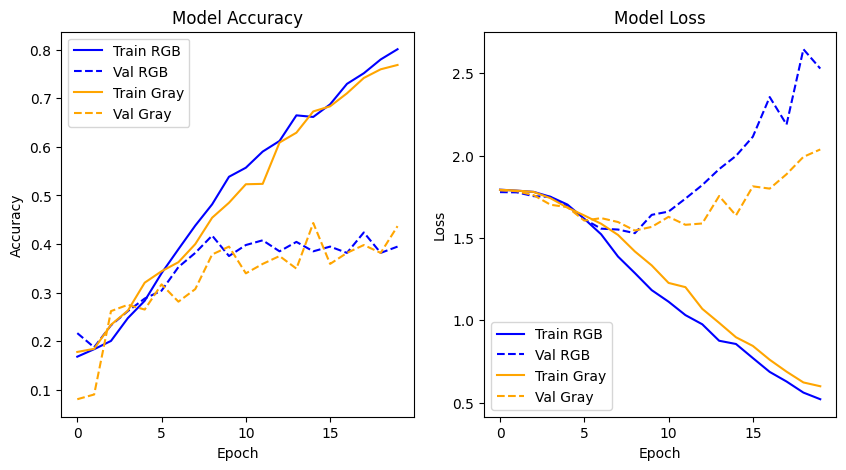

In [199]:
plot_compare_scores([history_rgb, history_gray], names=['RGB', 'Gray'])

Podemos observar que normalizar las imágenes en escala grises es igual o mejor que usar las imágenes en RGB, aún usando menos neuronas en la primera capa de la red neuronal debido a que la imagen tiene una capa en lugar de 3.

Principalmente se observa un mejor loss de validación. Por lo que usaremos estas imágenes de aquí en adelante.

Sin embargo, el loss sube para la validación, por lo que el modelo no parece adecuado.

## Selección del dataset

In [ ]:
#Usaremos las imágenes en gris para las siguientes comparaciones
X = X_gray
X_train = X_gray_train
X_test = X_gray_test
on_gray_scale=True

# Hiperparámetros de la red
batch_size=128
epochs = 20
validation_split = 0.2
img_rows,img_cols=IMG_SIZE,IMG_SIZE
num_channels = 1 if len(X_gray_train.shape)==3 else X_gray_train.shape[3]
input_shape = (img_rows, img_cols, num_channels) #(542, 64,64) >- GRIS; #(542, 64,64,3) >- RGB;

## Comparativa del número de parámetros

### Más neurones por capa

In [187]:
model = keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last", input_shape=input_shape, activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(6, activation='softmax')
  ])

model.summary()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_params_size_large=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)                   │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 275,366 (1.05 MB)

 Trainable params: 275,366 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - accuracy: 0.1678 - loss: 1.7958 - val_accuracy: 0.0906 - val_loss: 1.7890
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.1984 - loss: 1.7786 - val_accuracy: 0.1748 - val_loss: 1.7772
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.2544 - loss: 1.7574 - val_accuracy: 0.2913 - val_loss: 1.6953
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.2990 - loss: 1.6815 - val_accuracy: 0.2977 - val_loss: 1.6688
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.4007 - loss: 1.5333 - val_accuracy: 0.2977 - val_loss: 1.5802
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - accuracy: 0.4540 - loss: 1.3459 - val_accuracy: 0.4175 - val_loss: 1.4830
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.5727 - loss: 1.1786 - val_accuracy: 0.3786 - val_loss: 1.6325
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 368ms/step - accuracy: 0.5755 - loss: 1.0848 - val_accura

### Menos neuronas por capa

In [189]:
model = keras.Sequential([
  keras.layers.Conv2D(16, kernel_size=(3, 3), data_format="channels_last", input_shape=input_shape, activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(6, activation='softmax')
  ])

model.summary()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_params_size_small=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)                   │ (None, 62, 62, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_48 (MaxPooling2D)      │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 29, 29, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 12, 12, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 6, 6, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 4, 4, 16)            │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 2, 2, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,534 (33.34 KB)

 Trainable params: 8,534 (33.34 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.1752 - loss: 1.7939 - val_accuracy: 0.2460 - val_loss: 1.7651
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.1819 - loss: 1.7844 - val_accuracy: 0.2298 - val_loss: 1.7495
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.2148 - loss: 1.7708 - val_accuracy: 0.2427 - val_loss: 1.7719
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.2107 - loss: 1.7707 - val_accuracy: 0.2168 - val_loss: 1.7498
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.2510 - loss: 1.7434 - val_accuracy: 0.1456 - val_loss: 1.8284
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.2456 - loss: 1.7073 - val_accuracy: 0.2589 - val_loss: 1.6946
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.3046 - loss: 1.6420 - val_accuracy: 0.2589 - val_loss: 1.6941
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.3392 - loss: 1.5962 - val_accuracy: 0.2

### Comparativa de resultados en el número de parámetros

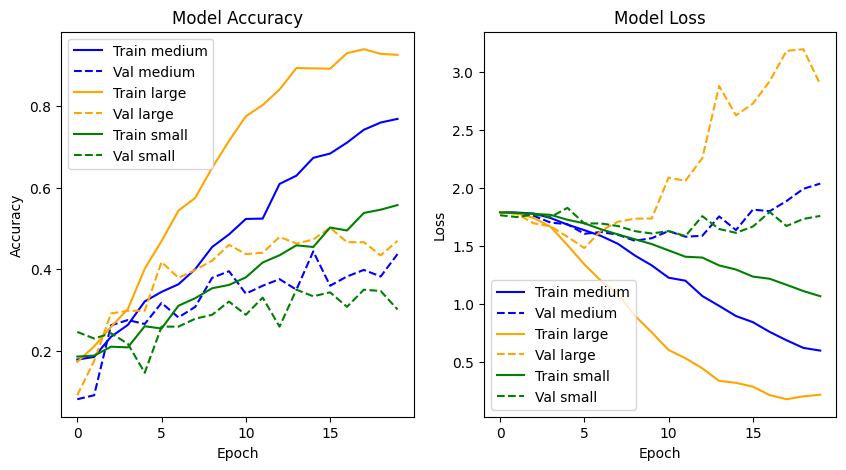

In [203]:
history_params_size_medium = history_gray
plot_compare_scores([history_params_size_medium, history_params_size_large, history_params_size_small], names=['medium', 'large', 'small'])

Aumentar demasiado los parámetros produce un sobrejuste y el modelo no será capaz generalizar. Bajar los parámetros respecto a los anteriores no logra entrenar suficiente el modelo. Por lo que optaremos por quedarnos con el número de neuroas que teníamos previamente.

## Función de creación del modelo

Función que crea un modelo en base a unos los parámetros indicados

In [211]:
def create_model(optimizer="adam", activation="relu", dropout=0, kernel_initializer=None, bias_initializer=None, kernel_regularizer=None):

  model = keras.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last", input_shape=input_shape, activation=activation),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation=activation),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation=activation),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation=activation),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(dropout),
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation=activation, kernel_initializer=kernel_initializer,
                      bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer),
    keras.layers.Dense(32, activation=activation, kernel_initializer=kernel_initializer,
                      bias_initializer=bias_initializer, kernel_regularizer=kernel_regularizer),
    keras.layers.Dropout(dropout),
    keras.layers.Dense(6, activation='softmax')
    ])

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

## Comparativa del optimizador

### SGD

In [212]:
model = create_model(optimizer="sgd", activation="relu", dropout=0, kernel_initializer=None, bias_initializer=None, kernel_regularizer=None)
history_optimizer_sgd=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.1454 - loss: 1.8072 - val_accuracy: 0.1909 - val_loss: 1.7902
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.1767 - loss: 1.7918 - val_accuracy: 0.1262 - val_loss: 1.7868
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.1912 - loss: 1.7889 - val_accuracy: 0.1197 - val_loss: 1.7844
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.2010 - loss: 1.7901 - val_accuracy: 0.1424 - val_loss: 1.7810
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.1983 - loss: 1.7882 - val_accuracy: 0.1230 - val_loss: 1.7792
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.2098 - loss: 1.7815 - val_accuracy: 0.2233 - val_loss: 1.7760
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.2110 - loss: 1.7847 - val_accuracy: 0.2104 - val_loss: 1.7742
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.1851 - loss: 1.7869 - val_accuracy: 0.

### RMSProp

In [213]:
model = create_model(optimizer="RMSprop", activation="relu", dropout=0, kernel_initializer=None, bias_initializer=None, kernel_regularizer=None)
history_optimizer_rmsprop=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 291ms/step - accuracy: 0.1593 - loss: 1.8078 - val_accuracy: 0.1100 - val_loss: 1.7964
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - accuracy: 0.2208 - loss: 1.7814 - val_accuracy: 0.2395 - val_loss: 1.7405
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 0.2190 - loss: 1.7736 - val_accuracy: 0.2168 - val_loss: 1.7522
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - accuracy: 0.2809 - loss: 1.7317 - val_accuracy: 0.1877 - val_loss: 1.7528
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.3195 - loss: 1.6689 - val_accuracy: 0.2557 - val_loss: 1.7126
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - accuracy: 0.3527 - loss: 1.6320 - val_accuracy: 0.3139 - val_loss: 1.6462
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 223ms/step - accuracy: 0.3550 - loss: 1.5955 - val_accuracy: 0.2945 - val_loss: 1.6418
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.4241 - loss: 1.4939 - val_accur

### Adamax

In [214]:
model = create_model(optimizer="adamax", activation="relu", dropout=0, kernel_initializer=None, bias_initializer=None, kernel_regularizer=None)
history_optimizer_adamax=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.1840 - loss: 1.8014 - val_accuracy: 0.2362 - val_loss: 1.7655
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.2303 - loss: 1.7795 - val_accuracy: 0.1133 - val_loss: 1.7888
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.2183 - loss: 1.7740 - val_accuracy: 0.2006 - val_loss: 1.7774
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.2648 - loss: 1.7558 - val_accuracy: 0.2848 - val_loss: 1.7325
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.2880 - loss: 1.7211 - val_accuracy: 0.2104 - val_loss: 1.7354
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.3037 - loss: 1.7005 - val_accuracy: 0.2362 - val_loss: 1.7156
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.3095 - loss: 1.6600 - val_accuracy: 0.2395 - val_loss: 1.6904
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.3290 - loss: 1.6315 - val_accuracy: 0

### Comparativa de resultados en el optimizador

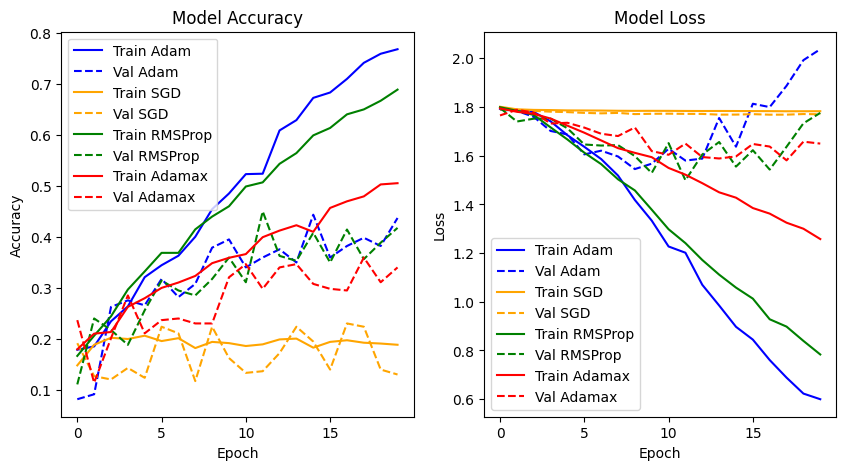

In [215]:
history_optimizer_adam = history_params_size_medium
plot_compare_scores([history_optimizer_adam, history_optimizer_sgd, history_optimizer_rmsprop, history_optimizer_adamax], names=['Adam', 'SGD', 'RMSProp', 'Adamax'])

Escogeremos RMSProp porque parece dar un resultado algo mejor que Adam en el loss de validation

## Reguladores: Tasa de Abondono (Dropout)

### 0.2

In [219]:
model = create_model(optimizer="RMSprop", activation="relu", dropout=0.2, kernel_initializer=None, bias_initializer=None, kernel_regularizer=None)
history_dropout_0_2=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.1920 - loss: 1.7931 - val_accuracy: 0.2589 - val_loss: 1.7778
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 277ms/step - accuracy: 0.1911 - loss: 1.7835 - val_accuracy: 0.1100 - val_loss: 1.7829
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.1788 - loss: 1.7911 - val_accuracy: 0.1456 - val_loss: 1.7726
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.2204 - loss: 1.7731 - val_accuracy: 0.2233 - val_loss: 1.7406
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 233ms/step - accuracy: 0.2626 - loss: 1.7432 - val_accuracy: 0.2298 - val_loss: 1.7050
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.2775 - loss: 1.7138 - val_accuracy: 0.2427 - val_loss: 1.7051
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.3116 - loss: 1.6967 - val_accuracy: 0.2136 - val_loss: 1.6688
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.2927 - loss: 1.6657 - val_accurac

### 0.5

In [221]:
model = create_model(optimizer="RMSprop", activation="relu", dropout=0.5, kernel_initializer=None, bias_initializer=None, kernel_regularizer=None)
history_dropout_0_5=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.1777 - loss: 1.8081 - val_accuracy: 0.1715 - val_loss: 1.7983
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.1633 - loss: 1.7909 - val_accuracy: 0.0841 - val_loss: 1.7908
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.1667 - loss: 1.7851 - val_accuracy: 0.0906 - val_loss: 1.7890
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.1813 - loss: 1.7896 - val_accuracy: 0.1877 - val_loss: 1.7857
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.1840 - loss: 1.7899 - val_accuracy: 0.2039 - val_loss: 1.7723
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.1876 - loss: 1.7820 - val_accuracy: 0.2233 - val_loss: 1.7652
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.1847 - loss: 1.7888 - val_accuracy: 0.2330 - val_loss: 1.7651
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.2423 - loss: 1.7707 - val_accuracy: 

### 0.8

In [222]:
model = create_model(optimizer="RMSprop", activation="relu", dropout=0.8, kernel_initializer=None, bias_initializer=None, kernel_regularizer=None)
history_dropout_0_8=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.1791 - loss: 1.9076 - val_accuracy: 0.0809 - val_loss: 1.8027
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.2008 - loss: 1.8132 - val_accuracy: 0.0841 - val_loss: 1.7902
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.1744 - loss: 1.8142 - val_accuracy: 0.1845 - val_loss: 1.7843
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.1647 - loss: 1.8048 - val_accuracy: 0.1942 - val_loss: 1.7860
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.1760 - loss: 1.7952 - val_accuracy: 0.1003 - val_loss: 1.7849
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.1706 - loss: 1.7910 - val_accuracy: 0.1845 - val_loss: 1.7839
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.1517 - loss: 1.7999 - val_accuracy: 0.1942 - val_loss: 1.7844
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.1827 - loss: 1.7965 - val_accuracy: 

### Comparativa de resultados con los valores de dropout

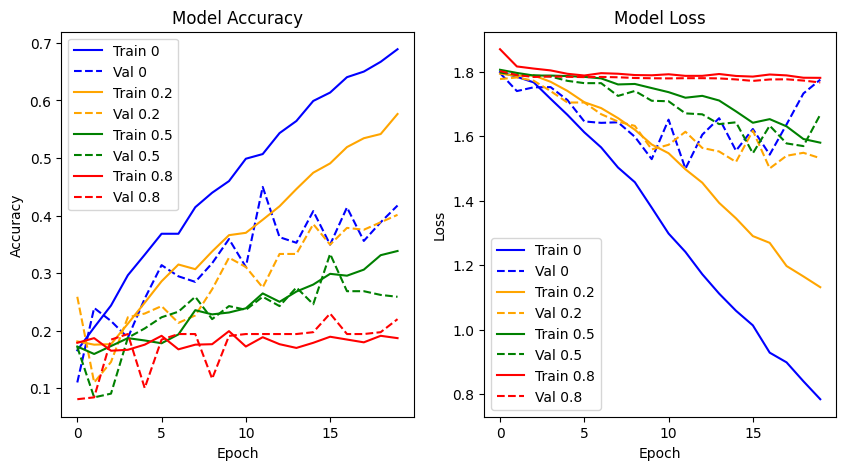

In [223]:
history_dropout_0 = history_optimizer_rmsprop
plot_compare_scores([history_dropout_0, history_dropout_0_2, history_dropout_0_5, history_dropout_0_8], names=['0', '0.2', '0.5', '0.8'])

Usar capaz de Dropout para regularizar la red neoronal ayuda en el valor de loss de validación

## Comparativa de la función de activación

### Sigmoid

In [225]:
model = create_model(optimizer="RMSprop", activation="sigmoid", dropout=0.2, kernel_initializer=None, bias_initializer=None, kernel_regularizer=None)
history_sigmoid=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.1759 - loss: 1.9641 - val_accuracy: 0.1942 - val_loss: 1.7676
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.1824 - loss: 1.8243 - val_accuracy: 0.1942 - val_loss: 1.7798
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.1710 - loss: 1.8337 - val_accuracy: 0.1942 - val_loss: 1.7862
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.1764 - loss: 1.8129 - val_accuracy: 0.2330 - val_loss: 1.7728
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.1928 - loss: 1.8111 - val_accuracy: 0.2330 - val_loss: 1.7844
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.1625 - loss: 1.8210 - val_accuracy: 0.2330 - val_loss: 1.7727
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.1893 - loss: 1.7985 - val_accuracy: 0.2589 - val_loss: 1.7717
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.1820 - loss: 1.7923 - val_accura

### Tangente Hiperbólica

In [226]:
model = create_model(optimizer="RMSprop", activation="tanh", dropout=0.2, kernel_initializer=None, bias_initializer=None, kernel_regularizer=None)
history_tanh=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.1845 - loss: 1.8530 - val_accuracy: 0.1068 - val_loss: 1.8057
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.2116 - loss: 1.7777 - val_accuracy: 0.2362 - val_loss: 1.7335
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.2814 - loss: 1.7019 - val_accuracy: 0.2104 - val_loss: 1.7671
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.3316 - loss: 1.6236 - val_accuracy: 0.2816 - val_loss: 1.6623
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.3832 - loss: 1.5330 - val_accuracy: 0.3430 - val_loss: 1.5950
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.4213 - loss: 1.4757 - val_accuracy: 0.3430 - val_loss: 1.6274
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.4791 - loss: 1.3722 - val_accuracy: 0.3430 - val_loss: 1.5698
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.5102 - loss: 1.3002 - val_accuracy: 0.

Comparativa de resultados con las funciones de activación

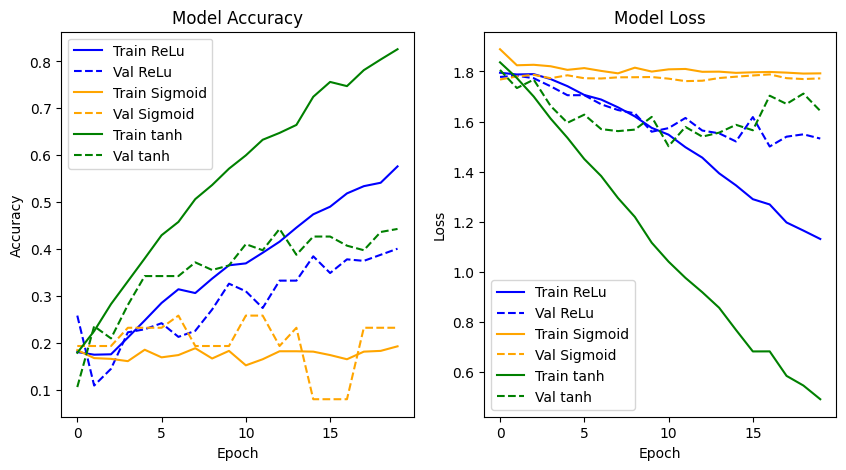

In [231]:
history_relu = history_dropout_0_2
plot_compare_scores([history_dropout_0_2, history_sigmoid, history_tanh], names=['ReLu', 'Sigmoid', 'tanh'])

Aunque la tangente hiperbólica parece tener mejor accuracy, nos quedamos con la función de activación ReLu porque es tiene algo menos de pérdidas en el loss de validación y porque es una función con menor coste de computación.

## Reguladores: L1,L2

### L1

In [233]:
model = create_model(optimizer="RMSprop", activation="relu", dropout=0.2, kernel_initializer=None, bias_initializer=None, kernel_regularizer=regularizers.L1(0.01))
history_regularizer_l1=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.1370 - loss: 6.6761 - val_accuracy: 0.2589 - val_loss: 5.2268
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.1719 - loss: 4.8798 - val_accuracy: 0.2621 - val_loss: 3.8871
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - accuracy: 0.1651 - loss: 3.6315 - val_accuracy: 0.1942 - val_loss: 2.9045
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.1677 - loss: 2.7435 - val_accuracy: 0.1942 - val_loss: 2.2867
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - accuracy: 0.1605 - loss: 2.2165 - val_accuracy: 0.1942 - val_loss: 2.0298
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.1828 - loss: 2.0057 - val_accuracy: 0.1942 - val_loss: 1.9077
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.1897 - loss: 1.9010 - val_accuracy: 0.2330 - val_loss: 1.8389
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 244ms/step - accuracy: 0.1578 - loss: 1.8453 - val_accuracy:

### L2

In [235]:
model = create_model(optimizer="RMSprop", activation="relu", dropout=0.2, kernel_initializer=None, bias_initializer=None, kernel_regularizer=regularizers.L2(0.01))
history_regularizer_l2=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.1751 - loss: 2.5113 - val_accuracy: 0.2589 - val_loss: 2.2362
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.1795 - loss: 2.2038 - val_accuracy: 0.2136 - val_loss: 2.0374
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.1552 - loss: 2.0256 - val_accuracy: 0.1942 - val_loss: 1.9120
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.1760 - loss: 1.9126 - val_accuracy: 0.2621 - val_loss: 1.8579
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.2006 - loss: 1.8554 - val_accuracy: 0.2395 - val_loss: 1.8051
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - accuracy: 0.2187 - loss: 1.8095 - val_accuracy: 0.2233 - val_loss: 1.7621
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.2756 - loss: 1.7526 - val_accuracy: 0.2168 - val_loss: 1.7312
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.2684 - loss: 1.7310 - val_accuracy: 

Comparativa de resultados de regularización

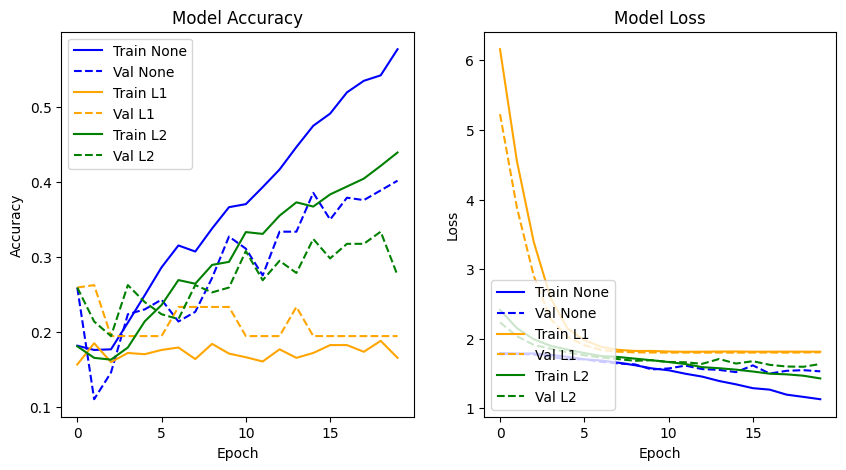

In [236]:
history_regularizer_none = history_relu
plot_compare_scores([history_regularizer_none, history_regularizer_l1, history_regularizer_l2], names=['None', 'L1', 'L2'])

En este caso usar regularización no parece haber mejorado los resultados anteriores

## Inicialización de pesos

Glorot Uniforme

In [239]:
model = create_model(optimizer="RMSprop", activation="relu", dropout=0.2, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', kernel_regularizer=None)
history_initializer_glorot=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.2067 - loss: 1.7898 - val_accuracy: 0.1942 - val_loss: 1.7839
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.1553 - loss: 1.7968 - val_accuracy: 0.2427 - val_loss: 1.7663
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.2024 - loss: 1.7913 - val_accuracy: 0.2816 - val_loss: 1.7639
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.2126 - loss: 1.7778 - val_accuracy: 0.2783 - val_loss: 1.7674
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.2068 - loss: 1.7764 - val_accuracy: 0.2330 - val_loss: 1.7494
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.2357 - loss: 1.7559 - val_accuracy: 0.2589 - val_loss: 1.7048
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.2997 - loss: 1.6943 - val_accuracy: 0.2233 - val_loss: 1.7020
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.3017 - loss: 1.6693 - val_accuracy:

Zeros

In [240]:
model = create_model(optimizer="RMSprop", activation="relu", dropout=0.2, kernel_initializer='zeros', bias_initializer='zeros', kernel_regularizer=None)
history_initializer_zeros=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - accuracy: 0.1622 - loss: 1.7916 - val_accuracy: 0.1942 - val_loss: 1.7895
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.1932 - loss: 1.7904 - val_accuracy: 0.1942 - val_loss: 1.7880
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.1883 - loss: 1.7898 - val_accuracy: 0.1942 - val_loss: 1.7870
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.1740 - loss: 1.7899 - val_accuracy: 0.1942 - val_loss: 1.7856
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.1765 - loss: 1.7901 - val_accuracy: 0.1942 - val_loss: 1.7848
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.1766 - loss: 1.7885 - val_accuracy: 0.1942 - val_loss: 1.7838
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.1629 - loss: 1.7886 - val_accuracy: 0.1942 - val_loss: 1.7829
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.1869 - loss: 1.7875 - val_accuracy: 0

Normal

In [241]:
model = create_model(optimizer="RMSprop", activation="relu", dropout=0.2, kernel_initializer='he_normal', bias_initializer='he_normal', kernel_regularizer=None)
history_initializer_normal=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.1693 - loss: 1.8085 - val_accuracy: 0.0874 - val_loss: 1.7897
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.1829 - loss: 1.7927 - val_accuracy: 0.1553 - val_loss: 1.7954
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.1876 - loss: 1.7893 - val_accuracy: 0.1909 - val_loss: 1.7692
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.2047 - loss: 1.7715 - val_accuracy: 0.2168 - val_loss: 1.7428
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.2909 - loss: 1.7148 - val_accuracy: 0.1909 - val_loss: 1.7279
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 0.2786 - loss: 1.7135 - val_accuracy: 0.1877 - val_loss: 1.7348
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.2927 - loss: 1.6850 - val_accuracy: 0.2104 - val_loss: 1.6890
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.3051 - loss: 1.6639 - val_accuracy:

Comparativa de resultados de inicializadores

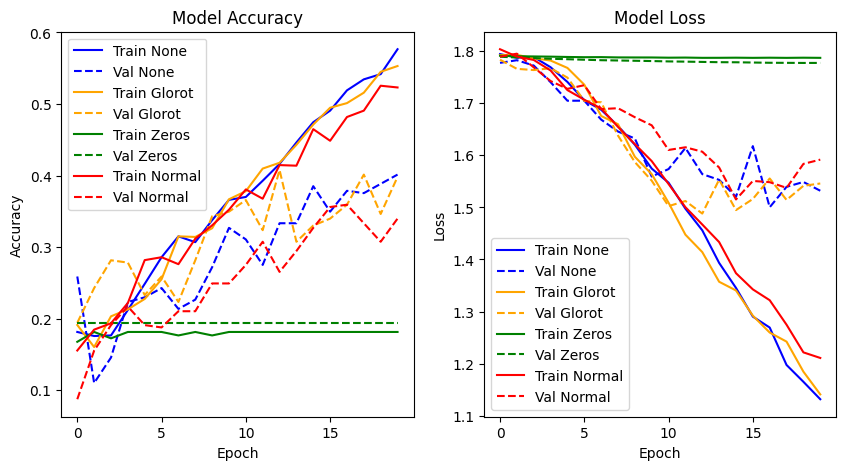

In [242]:
history_initializer_none = history_regularizer_none
plot_compare_scores([history_initializer_none, history_initializer_glorot, history_initializer_zeros, history_initializer_normal], names=['None', 'Glorot', 'Zeros', 'Normal'])

Usar inicializadores de pesos tampos mejora los resultados anteriores

# Selección personalizada de parámetros

En base a resultados anteriores, se ha optado por usar más neuronas, la función de activación "tanh" en las capas "Dense" y inicializadores tanto glorot como he_normal para los pesos y los bias.

Además, se ha usado el regularizador L2 para contrarrestar el overfitting que pudieran producir algunos de estos, por lo visto en las comparativas anteriores.

In [255]:
model = keras.Sequential([
  keras.layers.Conv2D(32, kernel_size=(3, 3), data_format="channels_last", input_shape=input_shape, activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(64, activation='tanh', kernel_initializer='glorot_normal',
                     bias_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)),
  keras.layers.Dense(128, activation='tanh', kernel_initializer='glorot_normal',
                     bias_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01)),
  keras.layers.Dropout(0.4),
  keras.layers.Dense(6, activation='softmax')
  ])

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_personalized=model.fit(X_train, y_train, epochs=epochs, validation_split = validation_split)

Epoch 1/20


Exception ignored in: <function _xla_gc_callback at 0x7b76429cf250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


39/39 ━━━━━━━━━━━━━━━━━━━━ 65s 300ms/step - accuracy: 0.1659 - loss: 3.3458 - val_accuracy: 0.2492 - val_loss: 2.7263
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 286ms/step - accuracy: 0.1684 - loss: 2.6217 - val_accuracy: 0.2427 - val_loss: 2.3221
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 413ms/step - accuracy: 0.2158 - loss: 2.2444 - val_accuracy: 0.2913 - val_loss: 1.9850
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 331ms/step - accuracy: 0.2639 - loss: 2.0286 - val_accuracy: 0.2265 - val_loss: 1.9403
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.2926 - loss: 1.9034 - val_accuracy: 0.2136 - val_loss: 1.8759
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 299ms/step - accuracy: 0.3331 - loss: 1.7932 - val_accuracy: 0.2524 - val_loss: 1.7922
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 23s 352ms/step - accuracy: 0.3382 - loss: 1.6921 - val_accuracy: 0.2071 - val_loss: 1.8639
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 286ms/step - accuracy: 0.3968 - loss: 1.5762 - val_accuracy: 0.265

Comparativa de resultados

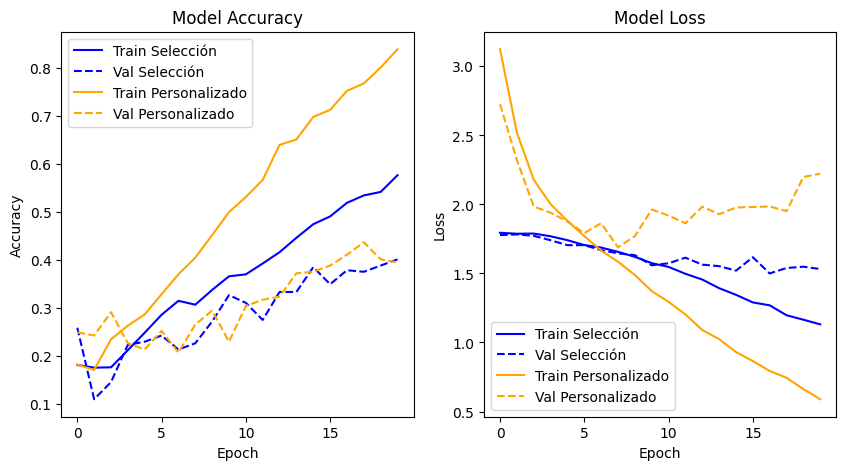

In [256]:
history_selected = history_initializer_none
plot_compare_scores([history_selected, history_personalized], names=['Selección', 'Personalizado'])

Con los cambios hechos al modelo se ha conseguido que el modelo mejore el loss para el set de validación y que se sobreajuste algo menos.

# Resultados con los datos de test

## Evaluación del modelo elegido

In [263]:
# Evaluación de los datos de entrenamiento
model.evaluate(X_train, y_train, batch_size=32, verbose=1)

49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.8522 - loss: 0.5615


[0.8886924386024475, 0.7636010646820068]

In [262]:
# Evaluación de los datos de test
model.evaluate(X_test, y_test, batch_size=32, verbose=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.5283 - loss: 1.7589


[1.943766474723816, 0.47891566157341003]

Según la validación, tenemos un precisión del 52% en los datos de test, un resultado mayor que el que obtuvimos con la validación.

## Predicción de los datos de test

In [321]:
y_pred=model.predict(X_test, batch_size=32, verbose=1)  # Almacenamos todas las predicciones para los datos de test
y_pred = np.array([np.argmax(y_sample) for y_sample in y_pred])
ytest_df = np.array([np.argmax(y_sample) for y_sample in y_test])

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step


### Función para mostrar la matriz de confusión

In [307]:
# Y finalmente visualizamos la Matriz de Confusión, para lo que se crea la siguiente función, que se llamará más adelante
# y_true     : dataframe -> Los valores de las clases que son ciertos (test)
# y_pred     : ndarray   -> Los valores calculados de las clases después de realizar la predicción
# classes    : ndarray   -> Los nombres de las clases/valores objetivos como array de numpy
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          titleSup=None,
                          fig=None,
                          ax=None):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if not fig:
      fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=titleSup,
           ylabel='True label',
           xlabel='Predicted label')
    ax.annotate(title, xy=(0.5, 1.1), xytext=(0, 10),
            xycoords='axes fraction', textcoords='offset points',
            ha='center', va='baseline', fontsize=10)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        title = 'Matriz de Confusión'
    else:
        title = 'Matriz de Confusión'

    fig.tight_layout()
    fig.suptitle(title, fontsize=16, y=1, ha='center')
    return ax

### Matriz de confusión

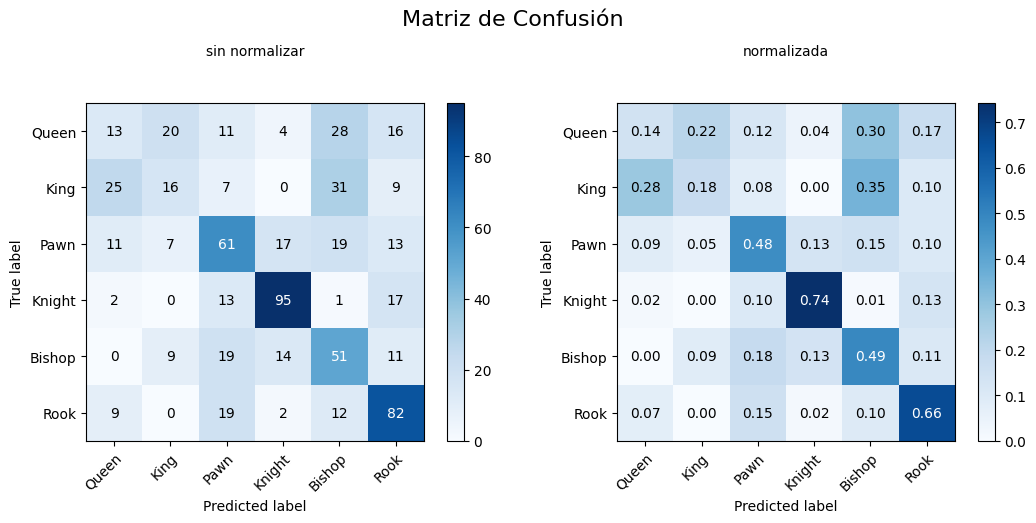

In [317]:
# Creamos el contenedor para representar los resultados
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (11,5))

# Creamos este array de numpy porque es el parámetro con las clases que espera la función
plot_confusion_matrix(ytest_df,
                      y_pred,
                      classes=np.array(list(MAP_CHARACTERS.values())),
                      normalize=False,
                      title='sin normalizar',
                      titleSup="",
                      fig=fig,
                      ax=ax[0]);

# Creamos este array de numpy porque es el parámetro con las clases que espera la función
plot_confusion_matrix(ytest_df,
                      y_pred,
                      classes=np.array(list(MAP_CHARACTERS.values())),
                      normalize=True,
                      title='normalizada',
                      titleSup="",
                      fig=fig,
                      ax=ax[1]);

Se puede observar que las piezas que peor predice son la Reina y el Rey. Por el contrario la que mejor se predice es el caballo seguida por la Torre.

### Informe

Análisis de resultados, obtención de métricas de precision y recall por clase y análisis de qué clases obtienen mejores o peores resultados.

In [322]:
informe = classification_report(ytest_df, y_pred)
print(informe)

              precision    recall  f1-score   support

           0       0.22      0.14      0.17        92
           1       0.31      0.18      0.23        88
           2       0.47      0.48      0.47       128
           3       0.72      0.74      0.73       128
           4       0.36      0.49      0.41       104
           5       0.55      0.66      0.60       124

    accuracy                           0.48       664
   macro avg       0.44      0.45      0.44       664
weighted avg       0.46      0.48      0.46       664

